In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression
from sklearn.utils import resample
from itertools import combinations

In [7]:
df = pd.read_csv('/Users/powellshayne/Desktop/githubrepos/VictorVis2.0/grid_collector/data/clean_player_stats.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   nickname         437 non-null    object 
 1   player_id        437 non-null    int64  
 2   series_count     437 non-null    int64  
 3   game_count       437 non-null    int64  
 4   total_kills      437 non-null    int64  
 5   avg_kills        437 non-null    float64
 6   max_kills        437 non-null    int64  
 7   min_kills        437 non-null    int64  
 8   total_deaths     437 non-null    int64  
 9   avg_deaths       437 non-null    float64
 10  max_deaths       437 non-null    int64  
 11  min_deaths       437 non-null    int64  
 12  kd_ratio         437 non-null    float64
 13  kills_per_game   437 non-null    float64
 14  deaths_per_game  437 non-null    float64
dtypes: float64(5), int64(9), object(1)
memory usage: 51.3+ KB
None


In [8]:
df =df.drop(columns='player_id', axis=1)
df  = df.set_index('nickname')
df.head()

,series_count,game_count,total_kills,avg_kills,max_kills,min_kills,total_deaths,avg_deaths,max_deaths,min_deaths,kd_ratio,kills_per_game,deaths_per_game
nickname,,,,,,,,,,,,,
marat2k 風速,37,89,1274,34.432432,61,14,1276,34.486486,68,13,0.998433,14.314607,14.337079
2high,22,53,750,34.090909,53,18,784,35.636364,47,18,0.956633,14.150943,14.792453
chawzyyy,4,9,134,33.500000,49,22,136,34.000000,43,18,0.985294,14.888889,15.111111
arvid,18,42,626,34.777778,63,20,633,35.166667,54,24,0.988942,14.904762,15.071429
ykis,5,10,165,33.000000,48,19,160,32.000000,42,18,1.031250,16.500000,16.000000


In [9]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index([], dtype='object')

In [10]:
X = df.drop('kd_ratio', axis=1)
y= df['kd_ratio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

## Feature Selection

In [11]:
corr_with_target = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print(corr_with_target.head(10))

kills_per_game     0.689218
avg_kills          0.548514
min_kills          0.399947
max_kills          0.333969
min_deaths         0.131040
deaths_per_game    0.054929
avg_deaths         0.052155
total_kills        0.042808
series_count       0.017631
game_count         0.016793
dtype: float64


In [12]:
rf = RandomForestRegressor(n_estimators=100, random_state=60)
rf.fit(X_train, y_train)

fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(fi_df.head(10))

            feature  importance
10   kills_per_game    0.496723
11  deaths_per_game    0.208710
8        max_deaths    0.067962
7        avg_deaths    0.059324
3         avg_kills    0.052379
6      total_deaths    0.036032
4         max_kills    0.034034
2       total_kills    0.017612
5         min_kills    0.012413
9        min_deaths    0.008735


## PCA

In [13]:
X_pca = df.drop('kd_ratio', axis=1)
y_pca= df['kd_ratio']

In [14]:
scale=  StandardScaler()
X_scaled = scale.fit_transform(X_pca)
print(X_scaled.shape)

(437, 12)


In [15]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

cum_var_rat = np.cumsum(pca.explained_variance_ratio_)

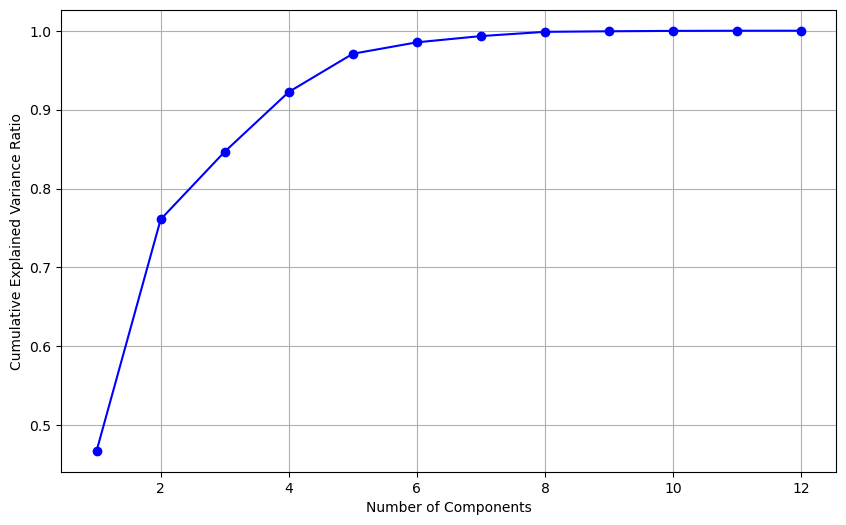

In [16]:
plt.figure(figsize=(10,6))
plt.plot(range(1, len(cum_var_rat)+1), cum_var_rat, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [17]:
n_components_95 = np.argmax(cum_var_rat >= 0.95) + 1
print(n_components_95)

pca_95 = PCA(n_components_95)
X_pca_95 = pca_95.fit_transform(X_scaled)

print(X_pca_95.shape)

5
(437, 5)


In [18]:
feat_names = X.columns

loadings = pd.DataFrame(
    pca_95.components_.T,
    columns = [f'PC{i+1}' for i in range(n_components_95)],
    index = feat_names
)

for  i in range(3):
    print(loadings[f'PC{i+1}'].abs().sort_values(ascending=False).head(10))

max_kills          0.352610
max_deaths         0.350686
total_kills        0.347986
total_deaths       0.347263
game_count         0.346049
series_count       0.343296
avg_kills          0.294591
avg_deaths         0.281888
kills_per_game     0.244831
deaths_per_game    0.216461
Name: PC1, dtype: float64
min_kills          0.390805
min_deaths         0.384857
avg_deaths         0.321843
avg_kills          0.315105
kills_per_game     0.286135
series_count       0.285460
deaths_per_game    0.284199
game_count         0.280330
total_deaths       0.274440
total_kills        0.272318
Name: PC2, dtype: float64
min_deaths        0.618885
max_kills         0.386880
kills_per_game    0.305479
min_kills         0.291950
avg_kills         0.217658
total_deaths      0.216599
game_count        0.199434
series_count      0.197214
total_kills       0.189733
max_deaths        0.186864
Name: PC3, dtype: float64


<function matplotlib.pyplot.show(close=None, block=None)>

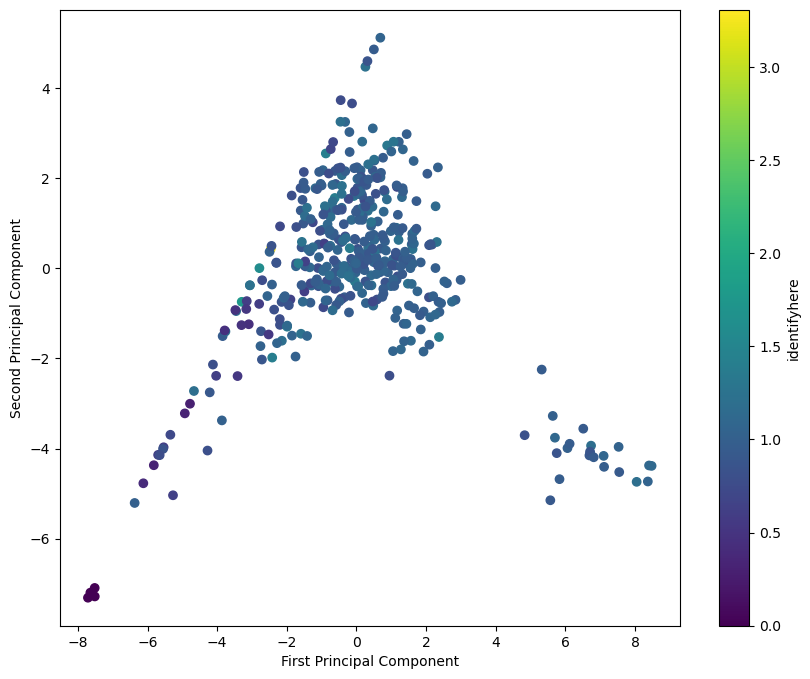

In [19]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_pca_95[:,0], X_pca_95[:,1],  c=y, cmap='viridis')
#identifyhere is a placeholder
plt.colorbar(scatter, label='identifyhere')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show


In [20]:
pca_df = pd.DataFrame(X_pca_95, columns = [f'PC{i+1}' for  i in range(n_components_95)])
pca_df['kd_ratio'] = y

correlations = pca_df.corr()['kd_ratio'].abs().sort_values(ascending=False)
print(correlations.head(10))

PC1        NaN
PC2        NaN
PC3        NaN
PC4        NaN
PC5        NaN
kd_ratio   NaN
Name: kd_ratio, dtype: float64


## Mutual Information

In [21]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
print(mi_scores)

kills_per_game     0.588590
avg_kills          0.401179
deaths_per_game    0.290001
max_deaths         0.252211
avg_deaths         0.231712
total_kills        0.181328
max_kills          0.171301
min_deaths         0.163893
total_deaths       0.159764
min_kills          0.127768
series_count       0.105994
game_count         0.097912
dtype: float64


## Stability Selection

In [22]:
from sklearn.utils import resample

def stability_selection(X, y, n_iterations=100, sample_fraction=0.75, n_estimators=100):
    feature_importances = np.zeros(X.shape[1])
    for _ in range(n_iterations):
        X_sample, y_sample = resample(X, y, n_samples=int(len(X) * sample_fraction))
        rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rf.fit(X_sample, y_sample)
        feature_importances += rf.feature_importances_
    return pd.Series(feature_importances / n_iterations, index=X.columns).sort_values(ascending=False)

stab_scores = stability_selection(X, y)
print(stab_scores)

kills_per_game     0.522316
deaths_per_game    0.199957
avg_kills          0.071716
max_kills          0.041388
total_kills        0.038445
avg_deaths         0.030665
min_kills          0.027103
max_deaths         0.026297
total_deaths       0.024424
min_deaths         0.011182
game_count         0.003692
series_count       0.002814
dtype: float64


In [25]:
X_train.to_csv('/Users/powellshayne/Desktop/githubrepos/VictorVis2.0/Shayne/X_train.csv')

X_test.to_csv('/Users/powellshayne/Desktop/githubrepos/VictorVis2.0/Shayne/X_test.csv')

y_train.to_csv('/Users/powellshayne/Desktop/githubrepos/VictorVis2.0/Shayne/y_train.csv')

y_test.to_csv('/Users/powellshayne/Desktop/githubrepos/VictorVis2.0/Shayne/y_test.csv')